# CTM MILP Formulation

In [1]:
import docplex.mp.model as cpx
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
from pprint import pprint

## Constants

In [2]:
# Constants from the parent paper

TOTAL_CELL_COUNT    = 32
MOVEMENT_CELLS      = 3 # Number of movement cells per approach
APPROACH_CELLS      = 3 # Number of cells in each approach
APPROACHES          = 4 # Number of approaches per intersection
APPROACH_LANES      = 4 # Number of lanes per approach

FREE_FLOW_SPEED     = 44 # ft / s
CELL_LENGTH         = 88 # ft
SAT_FLOW_RATE       = 1 # vehicles / timestep
FLOW_RATE_REDUCTION = 0.5 # Not speciifed
G_MIN               = 6 # seconds (change to 30)
G_MAX               = 20 # seconds (change to 120)

FLOW_UNDERSAT       = 450 # veh / hr / lane
FLOW_SAT            = 900 
FLOW_OVERSAT        = 1800

TURN_RATIO_LEFT     = 0.1
TURN_RATIO_THROUGH  = 0.8
TURN_RATIO_RIGHT    = 0.1
TURN_RATIOS = [
    TURN_RATIO_LEFT,
    TURN_RATIO_THROUGH,
    TURN_RATIO_RIGHT
]

LEFT_TURN_LANES     = 1
RIGHT_TURN_LANES    = 1
THROUGH_TURN_LANES  = APPROACH_LANES - LEFT_TURN_LANES - RIGHT_TURN_LANES
if THROUGH_TURN_LANES <= 0:
    THROUGH_TURN_LANES = 1
TURN_LANES = [
    LEFT_TURN_LANES,
    THROUGH_TURN_LANES,
    RIGHT_TURN_LANES
]

TIME_STEP           = 1 # seconds / time step; NOT FROM PAPER
TIME_RANGE          = 60 # run for this many seconds

MEAN_CAR_LENGTH     = 15.8 # ft

CELL_SOURCE         = 0
CELL_SINK           = 1
CELL_MOVEMENT       = 2
CELL_NORMAL         = 3

LEFT_TURN           = 0
THROUGH_TURN        = 1
RIGHT_TURN          = 2

## Sets

In [3]:
set_T = range(TIME_RANGE)
set_T_bounded = range(TIME_RANGE-1)

# Source cells: (0,approach_id)
set_C_O = [(CELL_SOURCE,0,i)
    for i in range(APPROACHES)]

# Sink cells: (0,approach_id)
set_C_S = [(CELL_SINK,0,i)
    for i in range(APPROACHES)]

# Movement cells: (movement_id, apporach_id)
set_C_I = [(CELL_MOVEMENT,i,j)
    for i in range(MOVEMENT_CELLS)
    for j in range(APPROACHES)]

# Normal cells: (cell_id, approach_id)
set_C_N = [(CELL_NORMAL,i,j)
    for i in range(APPROACH_CELLS)
    for j in range(APPROACHES)]

# Set of all cells: (cell_type, x, y)
set_C = set_C_O + set_C_S + set_C_I + set_C_N
set_C_labels = [
    'source',
    'sink',
    'movement',
    'normal'
]

In [4]:
def P_mapping(i):
    # 1. For source cells, return empty set
    if i[0] == CELL_SOURCE:
        return []
    # 2. For sink cells, return movement cells that lead to sink cell
    if i[0] == CELL_SINK:
        output = []
        # Add left turn of right approach
        output.append((CELL_MOVEMENT,LEFT_TURN,(i[2]+3)%4))
        # Add through turn of front approach
        output.append((CELL_MOVEMENT,THROUGH_TURN,(i[2]+2)%4))
        # Add right turn of left approach
        output.append((CELL_MOVEMENT,RIGHT_TURN,(i[2]+1)%4))
        return output
    # 3. For movement cells, return the previous cell
    if i[0] == CELL_MOVEMENT:
        return [(CELL_NORMAL,APPROACH_CELLS-1,i[2])]
    # 4. For normal cells, return the previous cell
    if i[0] == CELL_NORMAL:
        if i[1] == 0:
            return [(CELL_SOURCE,0,i[2])]
        else:
            return [(CELL_NORMAL,i[1]-1,i[2])]

def S_mapping(i):
    # 1. For source cells, return the next cell
    if i[0] == CELL_SOURCE:
        return [(CELL_NORMAL,0,i[2])]
    # 2. For sink cells, return the true sink
    if i[0] == CELL_SINK:
        return []
    # 3. For movement cells, return the sink cell
    if i[0] == CELL_MOVEMENT:
        return [(CELL_SINK,0,(i[2]+i[1]+1)%4)]
    # 4. For normal cells, return the next cell/s
    if i[0] == CELL_NORMAL:
        if i[1] == APPROACH_CELLS-1:
            return [(CELL_MOVEMENT,x,i[2]) for x in range(MOVEMENT_CELLS)]
        else:
            return [(CELL_NORMAL,i[1]+1,i[2])]

def J_mapping(i):
    # Only for movement cells
    if i[0] == CELL_MOVEMENT:
        # Rights conflict only the left approach's Through
        if i[1] == RIGHT_TURN:
            return [(CELL_MOVEMENT, THROUGH_TURN, (i[2]+1)%4)]
        # Throughs conflict a lot of things
        if i[1] == THROUGH_TURN:
            output = []
            output = output + [
                (CELL_MOVEMENT, LEFT_TURN, (i[2]+2)%4)
            ]
            output = output + [
                (CELL_MOVEMENT, LEFT_TURN, (i[2]+3)%4),
                (CELL_MOVEMENT, THROUGH_TURN, (i[2]+3)%4),
                (CELL_MOVEMENT, RIGHT_TURN, (i[2]+3)%4)
            ]
            output = output + [
                (CELL_MOVEMENT, LEFT_TURN, (i[2]+1)%4),
                (CELL_MOVEMENT, THROUGH_TURN, (i[2]+1)%4)
            ]
            return output
        if i[1] == LEFT_TURN:
            output = []
            output = output + [
                (CELL_MOVEMENT, THROUGH_TURN, (i[2]+2)%4)
            ]
            output = output + [
                (CELL_MOVEMENT, LEFT_TURN, (i[2]+3)%4),
                (CELL_MOVEMENT, THROUGH_TURN, (i[2]+3)%4)
            ]
            output = output + [
                (CELL_MOVEMENT, LEFT_TURN, (i[2]+1)%4),
                (CELL_MOVEMENT, THROUGH_TURN, (i[2]+1)%4)
            ]
            return output
            
        
P = {i: P_mapping(i)
    for i in set_C}

S = {i: S_mapping(i)
    for i in set_C}

J = {i: J_mapping(i)
    for i in set_C_I}

## Parameters

In [5]:
def M_mapping(i):
    if i in set_C_I:
        return (CELL_LENGTH / MEAN_CAR_LENGTH) * TURN_LANES[i[1]]
    elif i in set_C_O:
        return float("inf")
    return (CELL_LENGTH / MEAN_CAR_LENGTH) * APPROACH_LANES

def F_mapping(i):
    if i in set_C_I:
        return SAT_FLOW_RATE * TURN_LANES[i[1]]
    return SAT_FLOW_RATE * APPROACH_LANES

In [6]:
d = {(i,t): (float) (FLOW_SAT*APPROACH_LANES*TIME_STEP) / (3600)
    for i in set_C_O
    for t in set_T}

M = {i: M_mapping(i)
    for i in set_C}

F = {i: F_mapping(i)
    for i in set_C}

r = {i: TURN_RATIOS[i[1]]
    for i in set_C_I}

alpha = 0.8

## Initialize Model

In [7]:
model = cpx.Model(name="Thesis MILP model")

## Decision Variables

In [8]:
g_vars = {(i,t): model.binary_var(
    name="g_{}^{}".format(i,t))
for i in set_C_I
for t in set_T}

In [9]:
x_vars = {(i,t): model.continuous_var(
    lb=0,
    ub=M[i],
    name="x_{}^{}".format(i,t))
for i in set_C
for t in set_T}

In [10]:
y_vars = {(i,j,t): model.continuous_var(
    lb=0,
    ub=min(F[i],F[j]),
    name="y_{}_{}^{}".format(i,j,t))
for i in set_C
for j in S_mapping(i)
for t in set_T}

## Constraints

### Initial Values

In [11]:
init_src = [
    (model.add_constraint(
        ct=(
            x_vars[(i,0)]
            == d[(i,0)]
        ),
        ctname="init_src_{}".format(i)
    ))
    for i in set_C_O
]

init_rest = [
    (model.add_constraint(
        ct=(
            x_vars[(i,0)]
            == 0
        ),
        ctname="init_rest_{}".format(i)
    ))
    for i in set_C if i not in set_C_O
]

In [12]:
constraint_init = {
    'src': init_src
}

### Flow Conservation

In [13]:
flowcon_1 = [
    (model.add_constraint(
        ct=(
            model.sum(y_vars[(k,i,t)] for k in P[i])
            - model.sum(y_vars[(i,j,t)] for j in S[i])
            - x_vars[(i,t+1)]
            + x_vars[(i,t)]
            == 0
        ),
        ctname="flowcon_normal_{}^{}".format(i,t)
    ))
    for t in set_T_bounded
    for i in set_C_N + set_C_I
]

In [14]:
flowcon_2 = [
    (model.add_constraint(
        ct=(
            d[(i,t)]
            - model.sum(y_vars[(i,j,t)] for j in S[i])
            - x_vars[(i,t+1)]
            + x_vars[(i,t)]
            == 0
        ),
        ctname="flowcon_source_{}^{}".format(i,t)
    ))
    for t in set_T_bounded
    for i in set_C_O
]

In [15]:
flowcon_3 = [
    (model.add_constraint(
        ct=(
            model.sum(y_vars[(k,i,t)] for k in P[i])
            - x_vars[(i,t+1)]
            == 0
        ),
        ctname="flowcon_sink_{}^{}".format(i,t)
    ))
    for t in set_T_bounded
    for i in set_C_S
]

In [16]:
constraint_flowcon = {
    'source': flowcon_2,
    'sink': flowcon_3,
    'rest': flowcon_1
}

print("Expected constraint count: {}".format((TIME_RANGE-1) * TOTAL_CELL_COUNT))
print("Actual constraint count: {}".format(len(flowcon_1) + len(flowcon_2) + len(flowcon_3)))


Expected constraint count: 1888
Actual constraint count: 1888


### Flow Rate

In [17]:
flowrate_1 = [
    (model.add_constraint(
        ct=(
            model.sum(y_vars[(i,j,t)] for j in S[i])
            - x_vars[(i,t)]
            <= 0
        ),
        ctname="flowrate_srccap_{}^{}".format(i,t)
    ))
    for t in set_T
    for i in set_C if i not in set_C_S
]

In [18]:
flowrate_2 = [
    (model.add_constraint(
        ct=(
            model.sum(y_vars[(i,j,t)] for i in P[j])
            - M[j]
            + x_vars[(j,t)]
            <= 0
        ),
        ctname="flowrate_destcap_{}^{}".format(j,t)
    ))
    for t in set_T
    for j in set_C if j not in set_C_O
]

In [19]:
constraint_flowrate = {
    'source_cap': flowrate_1,
    'sink_cap': flowrate_2
}

print("Expected constraint count: {}".format(TIME_RANGE * (TOTAL_CELL_COUNT-4) * 2))
print("Actual constraint count: {}".format(len(flowrate_1) + len(flowrate_2)))

Expected constraint count: 3360
Actual constraint count: 3360


### Turning Ratios

In [20]:
turnratios = [
    (model.add_constraint(
        ct=(
            y_vars[(i,j,t)]
            - model.sum(r[j] * y_vars[(i,k,t)] for k in S[i])
            <= 0
        ),
        ctname="turnratios_{},{}^{}".format(i,j,t)
    ))
    for t in set_T
    for j in set_C_I
    for i in P[j]
]

In [21]:
constraint_turnratios = {
    'turn_ratios': turnratios
}

print("Expected constraint count: {}".format(TIME_RANGE * MOVEMENT_CELLS * APPROACHES))
print("Actual constraint count: {}".format(len(turnratios)))

Expected constraint count: 720
Actual constraint count: 720


### Movement Cell Flow Rate

In [22]:
green_flowrate = [
    (model.add_constraint(
        ct=(
            y_vars[(i,j,t)]
            - F[i]*g_vars[(i,t)]
            <= 0
        ),
        ctname="green_flowrate_{},{}^{}".format(i,j,t)
    ))
    for t in set_T
    for i in set_C_I
    for j in S[i]
]

In [23]:
slowstart_flowrate = [
    (model.add_constraint(
        ct=(
            y_vars[(i,j,t)]
            - F[i]
            + (F[i]*FLOW_RATE_REDUCTION)*g_vars[(i,t+1)]
            - (F[i]*FLOW_RATE_REDUCTION)*g_vars[(i,t)]
            <= 0
        ),
        ctname="slowstart_flowrate_{},{}^{}".format(i,j,t)
    ))
    for t in set_T_bounded
    for i in set_C_I
    for j in S[i]
]

In [24]:
constraint_greenflowrate = {
    'green_flowrate': green_flowrate,
    'slowstart_flowrate': slowstart_flowrate
}

print("Expected constraint count: {}".format((TIME_RANGE * MOVEMENT_CELLS * APPROACHES) + ((TIME_RANGE-1) * MOVEMENT_CELLS * APPROACHES)))
print("Actual constraint count: {}".format(len(green_flowrate) + len(slowstart_flowrate)))

Expected constraint count: 1428
Actual constraint count: 1428


### Collate all the constraints

In [25]:
constraints = {
    'flowcon': constraint_flowcon,
    'flowrate': constraint_flowrate,
    'turnratios': constraint_turnratios,
    'greenflowrate': constraint_greenflowrate,
    #'greentime': constraint_greentime,
    #'conflicts': constraint_conflicts,
    'init': constraint_init
}

total_constraints = 0

for _, constraint_dict in constraints.iteritems():
    for _, constraint_array in constraint_dict.iteritems():
        total_constraints = total_constraints + len(constraint_array)
        
print("Total constraint count: {}".format(total_constraints))

Total constraint count: 7400


## Objective Function

In [26]:
D_max = 1.0 / sum([ M[i] for i in set_C for t in set_T ])

D = model.sum(
    model.sum(
        x_vars[(i,t)] - model.sum(
            y_vars[(i,j,t)]
            for j in S_mapping(i))
        for i in set_C)
    for t in set_T)

F = model.sum(
        model.sum(
            model.sum(
                y_vars[(i,j,t)]
            for j in S[i])
        for i in set_C if i not in set_C_S)
    for t in set_T)

objective = D - 0.2*F

In [27]:
model.minimize(objective)

## Solving

In [28]:
print("Solving...")
model.solve()
print("Done!")

Solving...
Done!


## Showing the Cell Capacities

In [29]:
df_x_raw = pd.DataFrame.from_dict(x_vars, orient="index", 
                                columns = ["variable_object"])

df_x_raw.reset_index(inplace=True)
df_x_raw["volume"] = df_x_raw["variable_object"].apply(lambda item: item.solution_value)
df_x_raw['cell'] = df_x_raw['index'].apply(lambda x: x[0])
df_x_raw['timestep'] = df_x_raw['index'].apply(lambda x: x[1])

df_x = df_x_raw[['timestep', 'cell', 'volume']]
df_x

,timestep,cell,volume
0,57,"(2, 2, 1)",0.1
1,3,"(3, 0, 3)",1.0
2,26,"(1, 0, 3)",1.0
3,41,"(2, 1, 1)",0.8
4,6,"(3, 2, 3)",1.0
5,37,"(2, 2, 3)",0.1
6,51,"(0, 0, 2)",1.0
7,37,"(2, 1, 3)",0.8
8,26,"(1, 0, 1)",1.0
9,26,"(3, 2, 0)",1.0


In [40]:
df_x_source = df_x[df_x.cell == (CELL_SOURCE,0,1)].sort_values(by='timestep')
df_x_normal0 = df_x[df_x.cell == (CELL_NORMAL,0,1)].sort_values(by='timestep')
df_x_normal1 = df_x[df_x.cell == (CELL_NORMAL,1,1)].sort_values(by='timestep')
df_x_normal2 = df_x[df_x.cell == (CELL_NORMAL,2,1)].sort_values(by='timestep')
df_x_left = df_x[df_x.cell == (CELL_MOVEMENT,THROUGH_TURN,1)].sort_values(by='timestep')
df_x_sink = df_x[df_x.cell == S[(CELL_MOVEMENT,THROUGH_TURN,1)][0]].sort_values(by='timestep')

df_x_approach = df_x_source.append(df_x_normal1).append(df_x_normal2).append(df_x_normal0).append(df_x_left).append(df_x_sink)
df_x_approach = df_x_approach.pivot(index='timestep', columns='cell', values='volume')
df_x_approach

cell,"(0, 0, 1)","(1, 0, 3)","(2, 1, 1)","(3, 0, 1)","(3, 1, 1)","(3, 2, 1)"
timestep,,,,,,
0,1.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,1.0,0.0,0.0
2,1.0,0.0,0.0,1.0,1.0,0.0
3,1.0,0.0,0.0,1.0,1.0,1.0
4,1.0,0.0,0.8,1.0,1.0,1.0
5,1.0,1.0,0.8,1.0,1.0,1.0
6,1.0,1.0,0.8,1.0,1.0,1.0
7,1.0,1.0,0.8,1.0,1.0,1.0
8,1.0,1.0,0.8,1.0,1.0,1.0


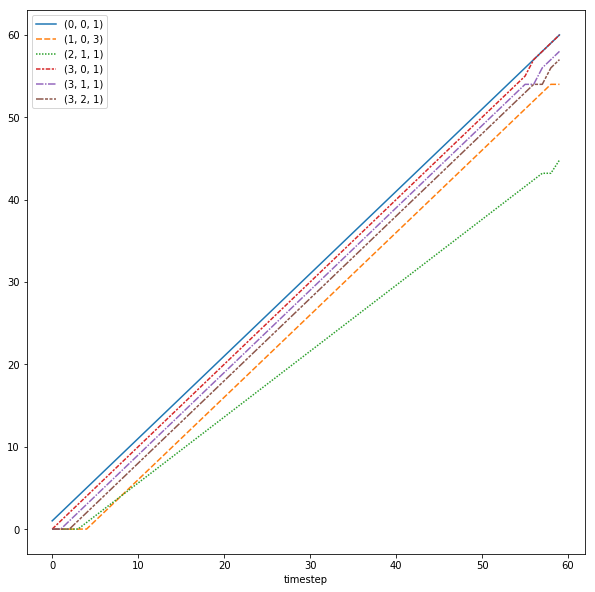

In [41]:
_, ax = plt.subplots(figsize=(10,10))
sns.lineplot(data=df_x_approach.cumsum())

This linear, cascading cumulative sum of consecutive cells (except for the through cell) means that the turning ratio is working fine.

In [42]:
df_y_raw = pd.DataFrame.from_dict(y_vars, orient="index", 
                                columns = ["variable_object"])

df_y_raw.reset_index(inplace=True)
df_y_raw["flow"] = df_y_raw["variable_object"].apply(lambda item: item.solution_value)
df_y_raw['cell_from'] = df_y_raw['index'].apply(lambda x: x[0])
df_y_raw['cell_to'] = df_y_raw['index'].apply(lambda x: x[1])
df_y_raw['timestep'] = df_y_raw['index'].apply(lambda x: x[2])

df_y = df_y_raw[['timestep', 'cell_from', 'cell_to', 'flow']]
df_y

,timestep,cell_from,cell_to,flow
0,54,"(2, 0, 0)","(1, 0, 1)",0.1
1,47,"(2, 0, 3)","(1, 0, 0)",0.1
2,13,"(0, 0, 3)","(3, 0, 3)",1.0
3,53,"(3, 1, 1)","(3, 2, 1)",1.0
4,22,"(2, 2, 0)","(1, 0, 3)",0.1
5,55,"(3, 0, 0)","(3, 1, 0)",0.0
6,14,"(3, 0, 1)","(3, 1, 1)",1.0
7,56,"(3, 2, 3)","(2, 1, 3)",0.8
8,10,"(3, 1, 0)","(3, 2, 0)",1.0
9,50,"(2, 2, 1)","(1, 0, 0)",0.1


In [43]:
df_y_source = df_y[df_y.cell_from == (CELL_SOURCE,0,1)].groupby(['cell_from', 'timestep']).agg({'flow': 'sum'}).sort_values(by='timestep')
df_y_normal0 = df_y[df_y.cell_from == (CELL_NORMAL,0,1)].groupby(['cell_from', 'timestep']).agg({'flow': 'sum'}).sort_values(by='timestep')
df_y_normal1 = df_y[df_y.cell_from == (CELL_NORMAL,1,1)].groupby(['cell_from', 'timestep']).agg({'flow': 'sum'}).sort_values(by='timestep')
df_y_normal2 = df_y[df_y.cell_from == (CELL_NORMAL,2,1)].groupby(['cell_from', 'timestep']).agg({'flow': 'sum'}).sort_values(by='timestep')
df_y_normal2 = df_y[df_y.cell_from == (CELL_NORMAL,2,1)].groupby(['cell_from', 'timestep']).agg({'flow': 'sum'}).sort_values(by='timestep')
df_y_left = df_y[df_y.cell_from == (CELL_MOVEMENT,LEFT_TURN,1)].groupby(['cell_from', 'timestep']).agg({'flow': 'sum'}).sort_values(by='timestep')
df_y_sink = df_y[df_y.cell_from == S[(CELL_MOVEMENT,LEFT_TURN,1)][0]].groupby(['cell_from', 'timestep']).agg({'flow': 'sum'}).sort_values(by='timestep')

df_y_approach = df_y_source.append(df_y_normal1).append(df_y_normal2).append(df_y_normal0).append(df_y_left).append(df_y_sink)
df_y_approach.reset_index(inplace=True)
df_y_approach = df_y_approach.pivot(index='timestep', columns='cell_from', values='flow')
df_y_approach

cell_from,"(0, 0, 1)","(2, 0, 1)","(3, 0, 1)","(3, 1, 1)","(3, 2, 1)"
timestep,,,,,
0,1.0,0.0,0.0,0.0,0.0
1,1.0,0.0,1.0,0.0,0.0
2,1.0,0.0,1.0,1.0,0.0
3,1.0,0.0,1.0,1.0,1.0
4,1.0,0.1,1.0,1.0,1.0
5,1.0,0.1,1.0,1.0,1.0
6,1.0,0.1,1.0,1.0,1.0
7,1.0,0.1,1.0,1.0,1.0
8,1.0,0.1,1.0,1.0,1.0


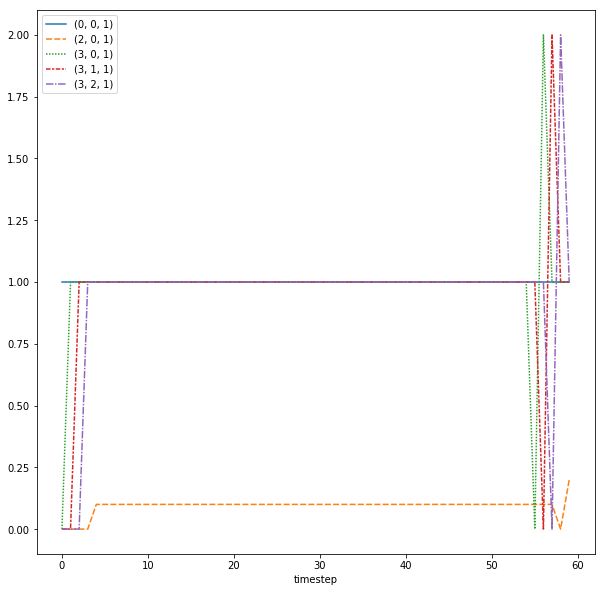

In [46]:
_, ax = plt.subplots(figsize=(10,10))
sns.lineplot(data=df_y_approach)